In [7]:
import torch
import jieba
import random

import numpy as np

from data import Data
from torch import nn, optim
from datetime import datetime
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

In [8]:
# Set random seed.
random_seed = 0

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [9]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda:0"

print(device)

cuda:0


In [10]:
classes = {
    0: "牡羊",
    1: "金牛",
    2: "雙子",
    3: "巨蠍",
    4: "獅子",
    5: "處女",
    6: "天秤",
    7: "天蠍",
    8: "射手",
    9: "魔羯",
    10: "水瓶",
    11: "雙魚",
}

In [11]:
raw = {i: open(f"./dataset/{classes[i]}.txt", encoding="utf-8").read() for i in range(12)}
data = Data(data=raw, padding_length=32)

train_raw = data.get("data")

Cleaning completed.
ToDataset completed.
Argumantation completed.


Tokenlization completed.
Padding completed.
Token2id completed.
Process completed.


In [12]:
len(train_raw)

4029

In [13]:
train_raw[0]

[[3041,
  1236,
  4104,
  1838,
  2960,
  2319,
  1656,
  147,
  3578,
  1887,
  1567,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093,
  1093],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [14]:
class CreateDataset(Dataset):
    def __init__(self, data: list, label: list):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.label[index], dtype=torch.float)

    def __len__(self):
        return len(self.label)

In [15]:
d, l = [], []

for i, j in train_raw:
    d.append(i); l.append(j)

train_ds = CreateDataset(d, l)

In [16]:
train_ds[1]

(tensor([3041, 1236, 4104, 1838, 2960, 2319, 1656,  147, 3578, 1887, 1567, 1093,
         1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093,
         1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [17]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

In [18]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.embedding = nn.Embedding(data.get("token_len"), 64)
        self.lstm = nn.LSTM(input_size=64, hidden_size=256, num_layers=4, dropout=0.5, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(16384, 12)

    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        x, _ = self.lstm(x)

        x = x.reshape(x.size()[0], -1)

        x = self.linear(x)

        return x

In [19]:
model = Model().to(device=device)

In [20]:
epochs = 15
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

In [21]:
# Traning history data.
train_accuracy_h = []
train_loss_h = []
validate_accuracy_h = []

In [22]:
def train(epochs: int, model: nn.Module, optimizer: optim.Optimizer, loss: nn.CrossEntropyLoss, dataloader: DataLoader):
    for epoch in range(epochs):
        # Set model to training mode.
        model.train()

        train_accuracy = 0
        train_loss = 0
        train_total = 0
        train_process = 0
        train_time = datetime.now().timestamp()

        for texts, labels in dataloader:
            texts: torch.Tensor
            labels: torch.Tensor

            texts = texts.to(device)
            labels = labels.to(device)

            outputs: torch.Tensor = model(texts)
            losses: torch.Tensor = loss(outputs, labels)

            # optimizer.zero_grad()
            for param in model.parameters(): param.grad = None

            # Backpropagation.
            losses.backward()

            # Update parameters.
            optimizer.step()

            _, predict = torch.max(outputs, 1)
            train_accuracy += sum([labels[i][predict[i]] == 1 for i in range(len(predict))])
            train_loss += losses.item()
            train_total += labels.shape[0]
            train_process += 1

            print(
                f"{datetime.now().strftime('%Y/%m/%d %H:%M:%S')} "
                f"Epoch: {epoch:03d} "
                f"Time: {datetime.now().timestamp() - train_time:.2f} "
                f"Process: {train_process / len(dataloader) * 100:.2f}% "
                f"Accuracy: {train_accuracy / train_total * 100:.2f}% "
                f"Loss: {train_loss:.3f}",
                end="\r"
            )

        train_accuracy_h.append(train_accuracy / train_total * 100)
        train_loss_h.append(train_loss)

        print()

        # Early stop.
        if train_accuracy / train_total > 99.5:
            print("Early stopped.")
            break

In [23]:
train(epochs=epochs, model=model, optimizer=optimizer, loss=loss, dataloader=train_dl)

2024/03/29 14:03:45 Epoch: 000 Time: 12.14 Process: 100.00% Accuracy: 15.34% Loss: 1212.813
2024/03/29 14:03:57 Epoch: 001 Time: 11.54 Process: 100.00% Accuracy: 16.18% Loss: 1198.745
2024/03/29 14:04:08 Epoch: 002 Time: 10.67 Process: 100.00% Accuracy: 19.51% Loss: 1169.402
2024/03/29 14:04:18 Epoch: 003 Time: 10.45 Process: 100.00% Accuracy: 27.13% Loss: 1099.519
2024/03/29 14:04:29 Epoch: 004 Time: 10.84 Process: 100.00% Accuracy: 35.34% Loss: 991.260
2024/03/29 14:04:40 Epoch: 005 Time: 10.56 Process: 100.00% Accuracy: 45.00% Loss: 862.534
2024/03/29 14:04:50 Epoch: 006 Time: 10.42 Process: 100.00% Accuracy: 56.04% Loss: 705.571
2024/03/29 14:05:00 Epoch: 007 Time: 10.44 Process: 100.00% Accuracy: 66.49% Loss: 542.832
2024/03/29 14:05:11 Epoch: 008 Time: 10.45 Process: 100.00% Accuracy: 77.79% Loss: 374.610
2024/03/29 14:05:21 Epoch: 009 Time: 10.52 Process: 100.00% Accuracy: 85.41% Loss: 241.960
2024/03/29 14:05:32 Epoch: 010 Time: 10.67 Process: 100.00% Accuracy: 89.45% Loss: 170

In [24]:
for i, j in train_dl:
    print(i)
    print(model(i.to(device)))
    print(j)
    break

tensor([[4182, 4090, 1952, 1406, 3884, 1033, 1236,  354,  585, 3903, 3578, 4112,
          436, 2207, 2747, 3489, 2719,   68, 1465,  436, 4309,  841, 3820, 2001,
          436, 2534,  875,  500, 1033, 4238, 3998, 2019],
        [2627, 1690, 4022, 2488,  436, 1616, 2409, 1414,  223, 1567, 1093, 1093,
         1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093,
         1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093],
        [1236, 1827,  929, 3578,  859,  153,  436,   79,  537,  436, 1391,  996,
         3578, 1831, 3489, 3879, 3578, 1189, 1677,  436, 4309, 3006, 1765,  436,
          168, 3012, 3396,  436, 1391, 2731,  687, 2203],
        [2719,  556, 2300, 4256,  436, 2704, 3578, 3547,  267,  986, 1567, 1093,
         1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093,
         1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093],
        [3928, 3959, 3578, 3361,  436, 1779, 4112, 2525, 3578, 1459, 2281,  561,
         1391,  886, 3578,  688, 1567, 

In [25]:
test = "敏感;同情心;想像力;迷惘;柔軟"
temp = jieba.lcut(test)
temp = temp + ["<PAD>"] * (32 - len(temp))
test = [data.w2i[x] if x in data.w2i else data.w2i["<PAD>"] for x in temp][:32]
print(test)

[3496, 1093, 3973, 1093, 177, 1093, 2151, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093]


In [26]:
test = torch.tensor([test])

In [27]:
model.eval()

Model(
  (embedding): Embedding(4328, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=16384, out_features=12, bias=True)
)

In [28]:
result = model(test.to(device)).tolist()[0]
print(result)

[1.3177989721298218, 0.24588723480701447, -1.733007788658142, 8.486858367919922, -2.4385716915130615, 1.1994291543960571, 1.1986534595489502, 0.2640247642993927, -3.948490858078003, -1.0473909378051758, -3.6633853912353516, 0.27099108695983887]


In [29]:
# Normolization
result = [x - min(result) for x in result]
result = [x / max(result) for x in result]
result = [round(x, 3) for x in result]

print(result)

[0.423, 0.337, 0.178, 1.0, 0.121, 0.414, 0.414, 0.339, 0.0, 0.233, 0.023, 0.339]


In [30]:
classes[int(torch.argmax(torch.tensor(result)))]

'巨蠍'

In [31]:
classes

{0: '牡羊',
 1: '金牛',
 2: '雙子',
 3: '巨蠍',
 4: '獅子',
 5: '處女',
 6: '天秤',
 7: '天蠍',
 8: '射手',
 9: '魔羯',
 10: '水瓶',
 11: '雙魚'}

In [32]:
import matplotlib.pyplot as plt
import numpy as np

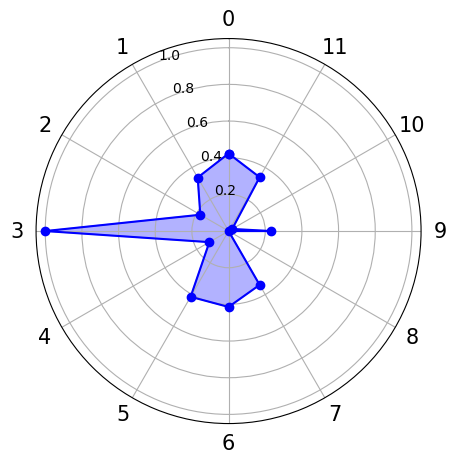

In [33]:
angles_A = np.linspace(start=0, stop=2*np.pi, num=len(result)+1, endpoint=True)
values_A = np.concatenate((result, [result[0]]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax.plot(angles_A, values_A, 'o-', color="blue", label="A")

ax.fill(angles_A, values_A, alpha=0.3, color="blue")
ax.set_thetagrids(angles_A[:-1] * 180 / np.pi, range(12), fontsize=15)
ax.set_theta_zero_location('N')

In [34]:
torch.onnx.export(model, test.to(device=device), 'constellator.onnx')

c:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torch\onnx\symbolic_opset9.py:4315: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
c:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
c:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torch\onnx\utils.py:687: UserWarning: The shape inference of prim::Con

In [35]:
import onnx
import onnx.helper

model = onnx.load('./constellator.onnx')
print(onnx.helper.printable_graph(model.graph))

graph torch_jit (
  %input.1[INT64, 1x32]
) initializers (
  %embedding.weight[FLOAT, 4328x64]
  %linear.weight[FLOAT, 12x16384]
  %linear.bias[FLOAT, 12]
  %onnx::LSTM_718[FLOAT, 2x2048]
  %onnx::LSTM_719[FLOAT, 2x1024x64]
  %onnx::LSTM_720[FLOAT, 2x1024x256]
  %onnx::LSTM_765[FLOAT, 2x2048]
  %onnx::LSTM_766[FLOAT, 2x1024x512]
  %onnx::LSTM_767[FLOAT, 2x1024x256]
  %onnx::LSTM_812[FLOAT, 2x2048]
  %onnx::LSTM_813[FLOAT, 2x1024x512]
  %onnx::LSTM_814[FLOAT, 2x1024x256]
  %onnx::LSTM_859[FLOAT, 2x2048]
  %onnx::LSTM_860[FLOAT, 2x1024x512]
  %onnx::LSTM_861[FLOAT, 2x1024x256]
) {
  %/embedding/Gather_output_0 = Gather(%embedding.weight, %input.1)
  %/lstm/Transpose_output_0 = Transpose[perm = [1, 0, 2]](%/embedding/Gather_output_0)
  %/lstm/Constant_output_0 = Constant[value = <Tensor>]()
  %/lstm/Constant_1_output_0 = Constant[value = <Tensor>]()
  %/lstm/Shape_output_0 = Shape(%/lstm/Transpose_output_0)
  %/lstm/Constant_2_output_0 = Constant[value = <Scalar Tensor []>]()
  %/lstm/Gat